Here is a quick look into the 16s that came from Werner's peat samples.

In [2]:
library(dada2)
library(phyloseq)
library(Biostrings)
library(ape)
library(ggplot2)
library(RColorBrewer)
load(file="/home/daniel/Documents/projects/wernerSphagnum/sequenceAnalysis/peat16sPS.rda")

In [15]:
options(repr.plot.width = 20, repr.plot.height = 10)

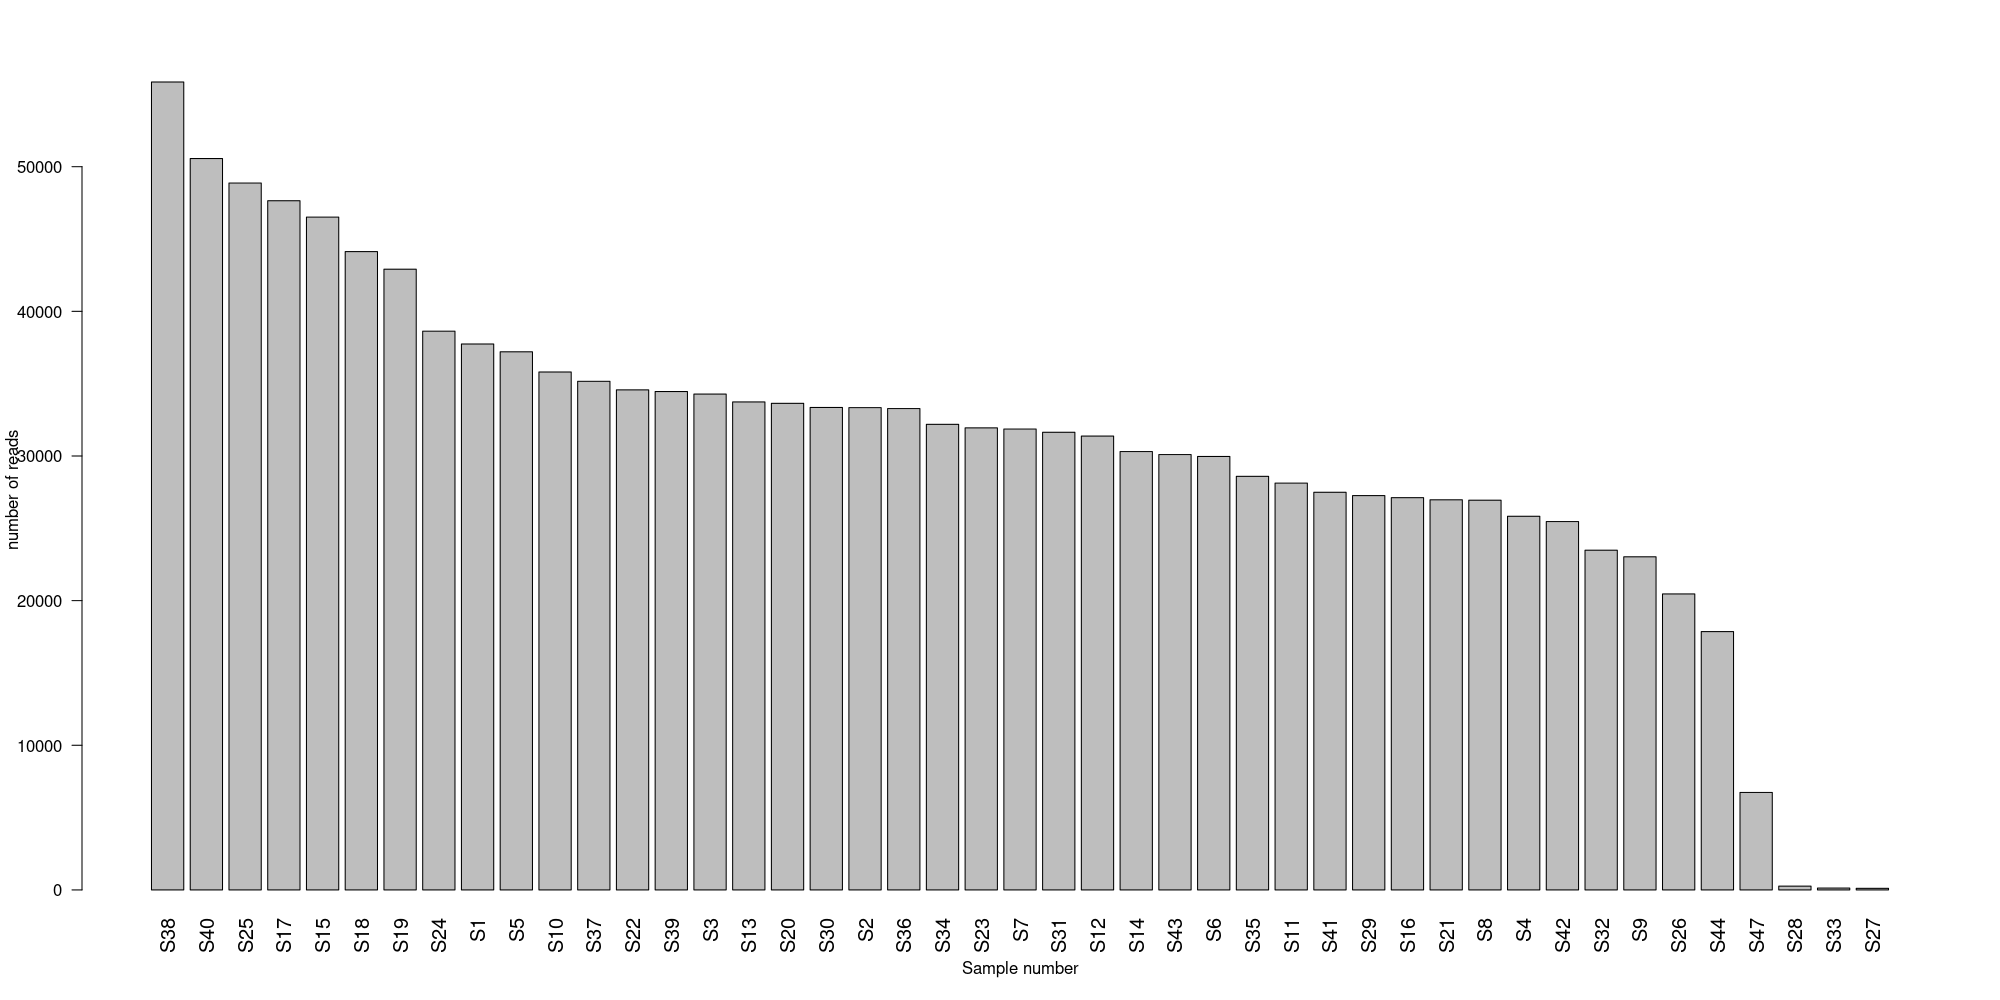

In [20]:
barplot(sort(sample_sums(ps), decreasing=TRUE), 
        ylab="number of reads",
        xlab="Sample number",
        cex.names=1.2, 
        las=2)

Looks like three samples essentially failed: S27, S28, and S33. These are:

In [21]:
sample_data(ps)[c("S27","S28","S33")]

,SampleID,Subsite,DepthSection,EcoCont,Core
,<chr>,<chr>,<dbl>,<chr>,<chr>
S27,AT2_43-63,Thermokarst,1,Ecological,AT2
S28,AT2_63-83,Thermokarst,2,Ecological,AT2
S33,AT3_80-100,Thermokarst,2,Ecological,AT3


Let's normalize by total read numbers in each sample (crude first adjustment to make them comparable). We'll also get ride of the low abundance samples and controls

In [23]:
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
nonCfilt <- sample_data(ps.prop)$EcoCont != "Control"
ps.prop.noC <- prune_samples(nonCfilt, ps.prop)
nonLowAbuFilt <- !(sample_names(ps.prop.noC) %in% c("S27","S28","S33"))
ps.prop.noC <- prune_samples(nonLowAbuFilt, ps.prop.noC)

Let's ordinate and label by depth and subsite (palsa or thermokarst):

In [25]:
s.prop.noC.ord <- ordinate(ps.prop.noC, "NMDS", "bray")

Run 0 stress 0.1280735 
Run 1 stress 0.1280735 
... New best solution
... Procrustes: rmse 2.62502e-06  max resid 9.780122e-06 
... Similar to previous best
Run 2 stress 0.1868194 
Run 3 stress 0.1280735 
... Procrustes: rmse 4.198068e-06  max resid 1.869143e-05 
... Similar to previous best
Run 4 stress 0.1280735 
... New best solution
... Procrustes: rmse 2.635242e-06  max resid 1.157272e-05 
... Similar to previous best
Run 5 stress 0.1280735 
... Procrustes: rmse 1.417934e-06  max resid 5.588234e-06 
... Similar to previous best
Run 6 stress 0.1946438 
Run 7 stress 0.2308912 
Run 8 stress 0.1280735 
... Procrustes: rmse 1.239668e-06  max resid 5.154216e-06 
... Similar to previous best
Run 9 stress 0.1868194 
Run 10 stress 0.1280735 
... Procrustes: rmse 1.142609e-06  max resid 3.432549e-06 
... Similar to previous best
Run 11 stress 0.1280735 
... Procrustes: rmse 1.410799e-06  max resid 5.815962e-06 
... Similar to previous best
Run 12 stress 0.1280735 
... Procrustes: rmse 9.522

In [ ]:
bb <- plot_ordination(ps.prop.noC, ps.prop.noC.ord, 
   color="DepthSection",
   shape="Subsite",
)

lbs <- geom_text(label=sample_data(ps.prop.noC)$Core,
                 color = "black",
                 nudge_x = 0.05, nudge_y = 0.05,
                 check_overlap = T)

myPalette <- colorRampPalette(rev(brewer.pal(8, "YlOrBr")))
sc <- scale_colour_gradientn(colours = myPalette(100), limits=c(5, 0), trans="reverse")
bb + sc + lbs + geom_point(size=3.5)

For some reason that won't work inside the jupyter notebook. Works on my terminal, this is the output:

<img src="ordinationPeat.png" width="950" height="450">